# NHANES Fasting Glucose Prediction Project  
### Author: Robert Giurcanu  
### Date: November 2025  

Two prediction models are developed for a clinical outcome (fasting glucose levels) using demographics, clinical biomarkers, dietary information, and other participant characteristics from the NHANES dataset (2021-2023 cycle) based on a statistical model (multiple linear regression) and a machine learning algorithm (Random Forest). In addition, a comparison in prediction performance between linear regression and Random Forest will be conducted using statistical measures.

## Data Sources

- **Demographics**: DEMO_L.XPT (age, sex)
- **Clinical biomarkers**: GLU_L.XPT (fasting glucose), GHB_L.XPT (glycated hemoglobin)  
- **Dietary information**: DR1TOT_L.xpt (number of calories, various macronutrients and micronutrients)
- **Other characteristics**: BMX_L.xpt (BMI, waist circumference), DIQ_L.xpt (diabetes diagnosis)

## Models Implemented
1. **Linear regression** (baseline model)
2. **Random Forest** (200 trees, max_depth=15)

## Summary Results

**Linear Regression Results:**
- R² Score: 0.325
- Mean Squared Error: 772.8
- Clinical Accuracy (within 10%): 67.8%
- Clinical Accuracy (within 15%): 80.8%

**Random Forest Results:**
- R² Score: 0.365
- Mean Squared Error: 727.3
- Clinical Accuracy (within 10%): 65.7%
- Clinical Accuracy (within 15%): 78.8%

**Feature Significance:**

    A patient that is diabetic exhibits the strongest association on fasting glucose for both the linear regression and the Random Forest models. Other similar results included waist circumference (second most significant in both models) and age. Contrastingly, the linear regression highlighted greater discrepancies regarding the number of calories, sex, and prediabetes, all of which were plotted as less notable in affecting fasting glucose levels.

**Residual vs. Predicted Glucose Distributions:**

    In both distributions, the Random Forest model demonstrates tighter residuals by consistently falling closer to 0 in comparison to the linear regression model. Random Forest predicts fasting glucose between 90–120 mg/dL with high accuracy; residuals typically range from -30 to 30 mg/dL. As the predicted glucose levels increase, the model visually predicts with less accuracy, though it summarizes measures across the entire range of fasting glucose levels. The linear regression model demonstrates similar characteristics with the Random Forest when predicting smaller glucose levels. However, it unusually exhibited two major clusters, highlighting its difficulty to predict fasting glucose levels between 120 to 145. 

In [1]:
# Import libraries
import pandas as pd            
import matplotlib.pyplot as plots 
from sklearn.model_selection import train_test_split 
from tableone import TableOne
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler



# The Machine Learning model
from sklearn.linear_model import LinearRegression

# Evaluating model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load data
diet = pd.read_sas('DR1TOT_L.xpt')
glu = pd.read_sas('GLU_L.XPT')
ghb = pd.read_sas('GHB_L.XPT')
demo = pd.read_sas('DEMO_L.XPT')
bmx = pd.read_sas('BMX_L.XPT')
diq = pd.read_sas('DIQ_L.XPT')

diet.to_csv('DR1TOT_L.csv', index = False)
glu.to_csv('GLU_L.csv', index = False)
ghb.to_csv('GHB_L.csv', index = False)
demo.to_csv('DEMO_L.csv', index = False)

diet = pd.read_csv('DR1TOT_L.csv')
glu = pd.read_csv('GLU_L.csv')
demo = pd.read_csv('DEMO_L.csv')
ghb = pd.read_csv('GHB_L.csv')

In [3]:
# Rename diet columns and create dataframe
rename_dict = {'DR1TKCAL': 'Calories','DR1TPROT': 'Protein_g','DR1TCARB': 'Carbs_g','DR1TSUGR': 'Sugar_g','DR1TFIBE': 'Fiber_g','DR1TTFAT': 'TotalFat_g','DR1TSFAT': 'SaturatedFat_g','DR1TMFAT': 'MonounsaturatedFat_g','DR1TPFAT': 'PolyunsaturatedFat_g','DR1TCHOL': 'Cholesterol_mg','DR1TSODI': 'Sodium_mg','DR1TPOTA': 'Potassium_mg'}



diet = diet.rename(columns = rename_dict)

# Create OtherFats_g = TotalFat - the fats
diet['OtherFats_g'] = (
    diet['TotalFat_g']
    - diet['SaturatedFat_g']
    - diet['MonounsaturatedFat_g']
    - diet['PolyunsaturatedFat_g']
)

bmx = bmx.rename(columns = {'BMXBMI': 'BMI', 'BMXWAIST': 'Waist_cm'})

diq = diq.rename(columns = {'DIQ010': 'Diabetes'})

demo = demo.rename(columns = {'RIAGENDR': 'Sex', 'RIDAGEYR': 'Age'})

# Fix Sex variable (RIAGENDR: 1 = Male, 2 = Female → 0 = Male, 1 = Female)
demo['Sex'] = demo['Sex'].replace({1: 0, 2: 1})

# Encode Diabetes: 0 = healthy, 1 = prediabetic, 2 = diabetes
# Original NHANES codes: 1 = Yes, 2 = No, 3 = prediabetic
diq['Diabetes'] = diq['Diabetes'].replace({2: 0, 3: 1, 1: 2})

# Create indicator variables for both models
diq['Prediabetic'] = (diq['Diabetes'] == 1).astype(int)
diq['Diabetic'] = (diq['Diabetes'] == 2).astype(int)

# Merge all data into one dataframe
data_frame = diet.merge(demo, on = 'SEQN')
data_frame = data_frame.merge(glu, on = 'SEQN')
data_frame = data_frame.merge(bmx[['SEQN', 'BMI', 'Waist_cm']], on = 'SEQN', how = 'left')
data_frame = data_frame.merge(diq[['SEQN', 'Diabetes', 'Prediabetic', 'Diabetic']], on = 'SEQN', how = 'left')

# Check the first few rows
print(data_frame[['Diabetes', 'Prediabetic', 'Diabetic']].head(10))


   Diabetes  Prediabetic  Diabetic
0       0.0            0         0
1       0.0            0         0
2       2.0            0         1
3       0.0            0         0
4       0.0            0         0
5       0.0            0         0
6       0.0            0         0
7       0.0            0         0
8       0.0            0         0
9       0.0            0         0


In [4]:
# Analyze the data using Model 1 (Linear Regression)
features = ['Calories','Protein_g','Carbs_g','Sugar_g','Fiber_g',
            'SaturatedFat_g','MonounsaturatedFat_g',
            'PolyunsaturatedFat_g','OtherFats_g',
            'Cholesterol_mg','Sodium_mg','Potassium_mg',
            'Sex','Age','BMI','Waist_cm','Prediabetic','Diabetic']

# Fasting Glucose  
target = 'LBXGLU'

# Clean missing values
data_frame = data_frame.dropna(subset = features + [target])

X = data_frame[features]
Y = data_frame[target]

# Split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
# Define columns for TableOne
columns = ['Age', 'Sex', 'BMI', 'Waist_cm', 'Diabetes','Calories','Protein_g','Carbs_g','Sugar_g','Fiber_g','TotalFat_g','SaturatedFat_g','MonounsaturatedFat_g','PolyunsaturatedFat_g','Cholesterol_mg','Sodium_mg','Potassium_mg']

# Categorical variables
categorical = ['Sex', 'Diabetes']

# Create the table
table1 = TableOne(
    data_frame,
    columns = columns,
    categorical = categorical,
    groupby = 'Diabetes',
    missing = True,
    pval = True   
)
print(table1)

                                    Grouped by Diabetes                                                                            
                                                Missing          Overall              0.0              1.0              2.0 P-Value
n                                                                   2795             2360               94              341        
Age, mean (SD)                                        0      51.0 (20.0)      48.9 (20.5)      59.4 (16.0)      63.1 (11.0)  <0.001
Sex, n (%)                      0.0                          1254 (44.9)      1019 (43.2)        48 (51.1)       187 (54.8)  <0.001
                                1.0                          1541 (55.1)      1341 (56.8)        46 (48.9)       154 (45.2)        
BMI, mean (SD)                                        0       29.2 (7.1)       28.6 (6.9)       33.1 (8.1)       32.1 (7.0)  <0.001
Waist_cm, mean (SD)                                   0      99.4 (17.3)    

In [6]:
# Predict fasting glucose on model
Y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(Y_test, Y_pred))
print("R² Score:", r2_score(Y_test, Y_pred))

coef_data_frame = pd.DataFrame({'feature': features, 'coefficient': model.coef_})
print(coef_data_frame)


Mean Squared Error: 772.8001856536672
R² Score: 0.32544714274712483
                 feature  coefficient
0               Calories     2.266706
1              Protein_g    -0.530805
2                Carbs_g    -1.317451
3                Sugar_g     1.352605
4                Fiber_g     1.039426
5         SaturatedFat_g    -1.463711
6   MonounsaturatedFat_g    -0.147536
7   PolyunsaturatedFat_g    -0.022440
8            OtherFats_g     0.411408
9         Cholesterol_mg     0.321623
10             Sodium_mg    -0.027409
11          Potassium_mg    -1.507586
12                   Sex    -1.767565
13                   Age     1.933627
14                   BMI    -0.302143
15              Waist_cm     3.473101
16           Prediabetic     2.134663
17              Diabetic    16.013122


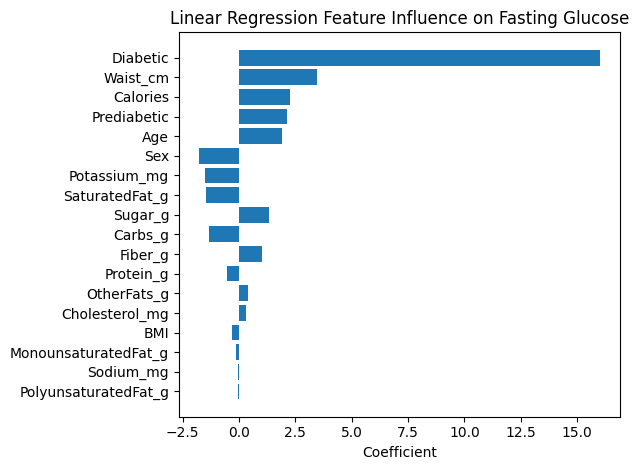

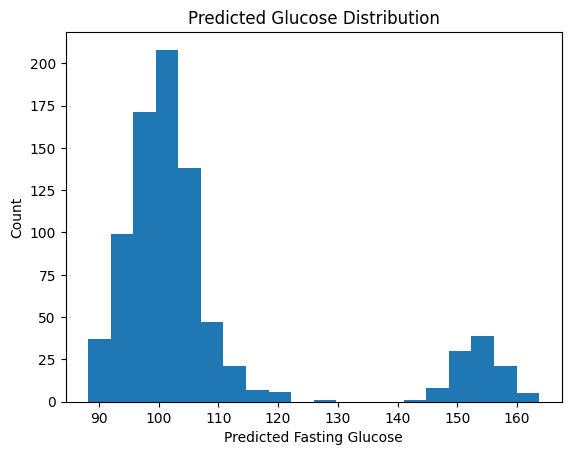

In [7]:
# Visualize feature importance and predicted glucose distribution

# Sort coefficients by absolute value
coef_data_frame = coef_data_frame.reindex(
    coef_data_frame['coefficient'].abs().sort_values(ascending=True).index
)

# Horizontal bar plot
plots.barh(coef_data_frame['feature'], coef_data_frame['coefficient'])
plots.xlabel('Coefficient')
plots.title('Linear Regression Feature Influence on Fasting Glucose')
plots.tight_layout()
plots.show()

# Histogram of predicted glucose
plots.hist(Y_pred, bins = 20)
plots.xlabel('Predicted Fasting Glucose')
plots.ylabel('Count')
plots.title('Predicted Glucose Distribution')
plots.show()

In [8]:
# Cross validation (10 folds) to check how stable the model is

# setting up 10 splits
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

# standardize x
X_cross = scaler.fit_transform(X)

# r2 scores for each fold
cv_r2 = cross_val_score(model, X_cross, Y, cv = kf, scoring = 'r2')
print("R2 scores:", cv_r2)
print("R2 mean:", np.mean(cv_r2))

# mse scores - flip it
cv_mse = cross_val_score(model, X_cross, Y, cv = kf, scoring = 'neg_mean_squared_error')
cv_mse = -cv_mse
print("MSE scores:", cv_mse)
print("MSE mean:", np.mean(cv_mse))

R2 scores: [0.35511306 0.29460008 0.35121827 0.24098906 0.38700433 0.32101579
 0.27064332 0.28813333 0.34681174 0.47873963]
R2 mean: 0.33342686064898885
MSE scores: [ 747.1299428  1001.15103844  554.29460935  753.99898937  691.66702654
  647.14252774  582.6084579   552.38072018  546.07079094  449.68804733]
MSE mean: 652.613215059407


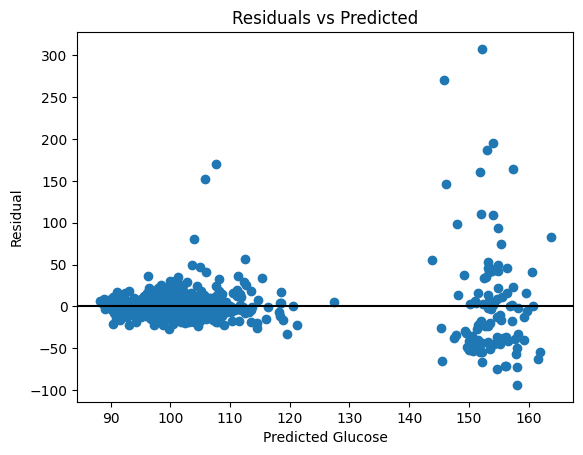

In [9]:
# Making a residual plot - prediction distribution

residuals = Y_test - Y_pred

plots.scatter(Y_pred, residuals)
plots.axhline(0, color = 'black')  # baseline
plots.xlabel("Predicted Glucose")
plots.ylabel("Residual")
plots.title("Residuals vs Predicted")
plots.show()

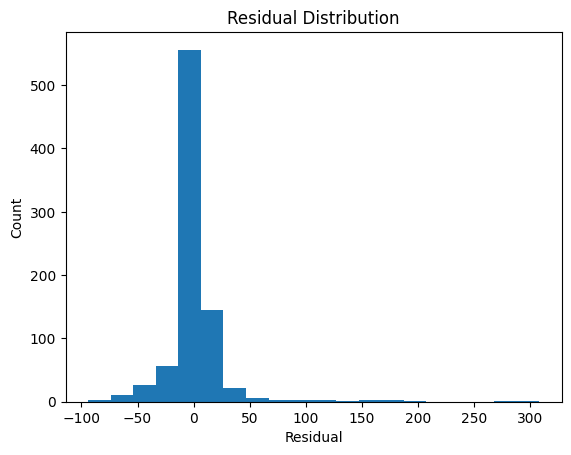

In [10]:
# Histogram of residuals to show how the errors are spread out

plots.hist(residuals, bins = 20)
plots.xlabel("Residual")
plots.ylabel("Count")
plots.title("Residual Distribution")
plots.show()

In [11]:
# Model 2: Random Forest for Glucose Prediction
# Initialize and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators = 200,
    max_depth = 15, 
    min_samples_split = 20,
    min_samples_leaf = 10,
    random_state = 42,
    n_jobs = -1
)

rf_model.fit(X_train, Y_train)

# Predict with Random Forest
Y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest performance
print("Random Forest Performance:")
print("Mean Squared Error:", mean_squared_error(Y_test, Y_pred_rf))
print("R² Score:", r2_score(Y_test, Y_pred_rf))

Random Forest Performance:
Mean Squared Error: 731.05914154567
R² Score: 0.3618815808987562


In [12]:
# Compare Linear Regression vs Random Forest
print("=== MODEL COMPARISON ===")
print("Linear Regression R²:", r2_score(Y_test, Y_pred))
print("Random Forest R²:", r2_score(Y_test, Y_pred_rf))
print("Linear Regression MSE:", mean_squared_error(Y_test, Y_pred))
print("Random Forest MSE:", mean_squared_error(Y_test, Y_pred_rf))

=== MODEL COMPARISON ===
Linear Regression R²: 0.32544714274712483
Random Forest R²: 0.3618815808987562
Linear Regression MSE: 772.8001856536672
Random Forest MSE: 731.05914154567


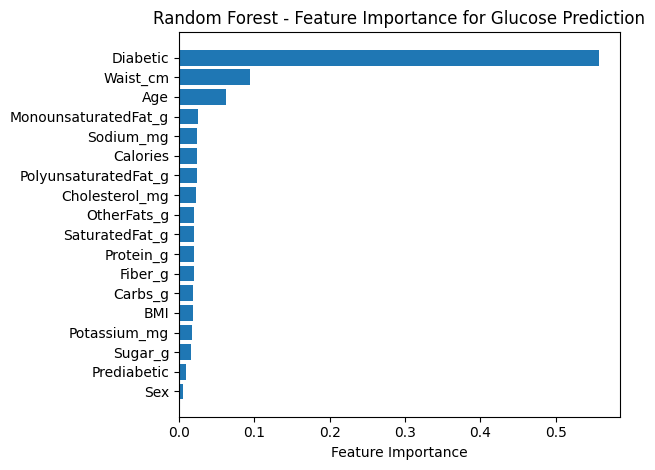

In [13]:
# Random Forest Feature Importance
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot feature importance
plots.barh(feature_importances['feature'], feature_importances['importance'])
plots.xlabel('Feature Importance')
plots.title('Random Forest - Feature Importance for Glucose Prediction')
plots.tight_layout()
plots.show()

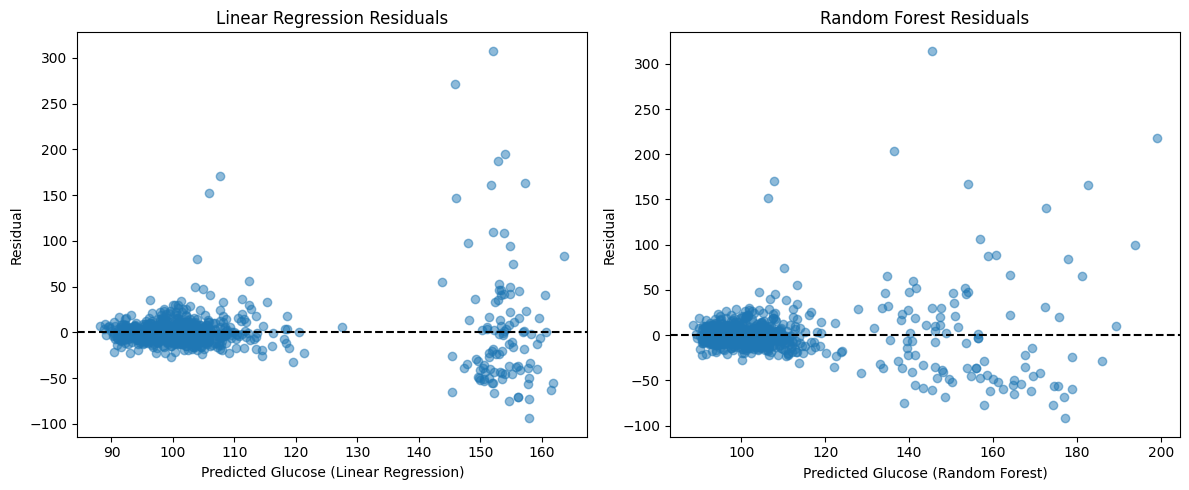

In [14]:
# Compare residuals between both models
residuals_lr = Y_test - Y_pred  # Linear Regression residuals
residuals_rf = Y_test - Y_pred_rf  # Random Forest residuals

# Create side-by-side residual plots
fig, (ax1, ax2) = plots.subplots(1, 2, figsize = (12, 5))

# Linear Regression residuals
ax1.scatter(Y_pred, residuals_lr, alpha = 0.5)
ax1.axhline(0, color = 'black', linestyle = '--')
ax1.set_xlabel('Predicted Glucose (Linear Regression)')
ax1.set_ylabel('Residual')
ax1.set_title('Linear Regression Residuals')

# Random Forest residuals
ax2.scatter(Y_pred_rf, residuals_rf, alpha = 0.5)  
ax2.axhline(0, color = 'black', linestyle = '--')
ax2.set_xlabel('Predicted Glucose (Random Forest)')
ax2.set_ylabel('Residual')
ax2.set_title('Random Forest Residuals')

plots.tight_layout()
plots.show()

In [15]:
# Clinical utility comparison between models
def evaluate_clinical_utility(y_true, y_pred, model_name):
    within_10_percent = np.mean(np.abs(y_true - y_pred) / y_true <= 0.10) * 100
    within_15_percent = np.mean(np.abs(y_true - y_pred) / y_true <= 0.15) * 100
    
    print(f"{model_name} Clinical Accuracy:")
    print(f"  Predictions within 10% of actual: {within_10_percent:.1f}%")
    print(f"  Predictions within 15% of actual: {within_15_percent:.1f}%")

evaluate_clinical_utility(Y_test, Y_pred, "Linear Regression")
evaluate_clinical_utility(Y_test, Y_pred_rf, "Random Forest")

Linear Regression Clinical Accuracy:
  Predictions within 10% of actual: 67.8%
  Predictions within 15% of actual: 80.8%
Random Forest Clinical Accuracy:
  Predictions within 10% of actual: 65.7%
  Predictions within 15% of actual: 78.8%


In [16]:
# Cross-validation for Random Forest
rf_cv_r2 = cross_val_score(rf_model, X, Y, cv = kf, scoring = 'r2')
rf_cv_mse = -cross_val_score(rf_model, X, Y, cv = kf, scoring = 'neg_mean_squared_error')

print("Random Forest Cross-Validation:")
print("R2 scores:", rf_cv_r2)
print("R2 mean:", np.mean(rf_cv_r2))
print("MSE scores:", rf_cv_mse) 
print("MSE mean:", np.mean(rf_cv_mse))

Random Forest Cross-Validation:
R2 scores: [0.41886964 0.25443762 0.33390793 0.31041954 0.41778679 0.37144897
 0.2038873  0.31878595 0.37514847 0.45121073]
R2 mean: 0.345590295101157
MSE scores: [ 673.26513868 1058.15230003  569.083906    685.02697575  656.93396825
  599.07446557  635.93301359  528.59548138  522.38104656  473.43705997]
MSE mean: 640.1883355771909


# Discussion

## Conclusion

This study evaluates that both linear regression and Random Forest models provide meaningful predictions of fasting glucose. Several feature influences among the two models were highlighted in similar ways, particularly diabetes, waist circumference, and age. It is evident that although linear regression is a relatively simple algorithm, using it to establish an evaluation is still plausible. However, in terms of model performance, Random Forest more accurately predicts fasting glucose based upon the clinical data used. Random Forest's R² was 0.04 greater (0.325 compared to 0.365) and its mean squared error was 45.5 less (727.3 to 772.8). Surprisingly, clinical accuracy among the two models were relatively homogenous. Despite these comparisons, the residual distributions highlighted differences in model performance, as the residuals vs. predicted glucose values for the Random Forest were generally widely distributed but centered around zero. In contrast the linear regression model exhibited two major clusters, with predictions between 140 to 170 deviating significantly from the correct glucose measurement. The performance of the model is likely due to the inherent non-linear behavior of predicting fasting glucose.

## Limitations and Further Improvement

    The linear regression and Random Forest models had low R² values (0.3–0.4), indicating there is room for improvement. 
    
    Using additional models would improve predictive accuracy of fasting glucose.

    Incorporating additional biomarkers and lifestyle factors will better support the goal for this project.
    

